## Build your own training/testing split

#### Date: 2021.10.07

When working with machine learning data, splitting into a "train", "dev" (or validation) and "test") set is important. Models use **train** data to learn representations and update their parameters; **dev** or validation data is reserved to see how the model may perform on unknown predictions. While it may not be explicitly trained on, it can be used as a stopping criteria, for hyper-parameter tuning, or as a simple sanity check. Lastly, **test** data is always reserved, hidden from the model, as a final pass to see what models perform best.

Lightwood supports a variety of **encoders** (Feature engineering procedures) and **mixers** (predictor algorithms that go from feature vectors to the target). Given the diversity of algorithms, it is appropriate to split data into these three categories when *preparing* encoders or *fitting* mixers.

Our default approach stratifies labeled data to ensure your train, validation, and test sets are equally represented in all classes. However, in many instances you may want a custom technique to build your own splits. We've included the `splitter` functionality (default found in `lightwood.data.splitter`) to enable you to build your own.

In the following problem, we shall work with a Kaggle dataset around credit card fraud (found [here](https://www.kaggle.com/mlg-ulb/creditcardfraud)). Fraud detection is difficult because the events we are interested in catching are thankfully rare events. Because of that, there is a large **imbalance of classes** (in fact, in this dataset, less than 1% of the data are the rare-event).

In a supervised technique, we may want to ensure our training data sees the rare event of interest. A random shuffle could potentially miss rare events. We will implement **SMOTE** to increase the number of positive classes in our training data.

Let's get started!

In [1]:
import numpy as np
import pandas as pd
import torch
import nltk
import matplotlib.pyplot as plt

import os
import sys

# Lightwood modules
import lightwood as lw
from lightwood import ProblemDefinition, \
                      JsonAI, \
                      json_ai_from_problem, \
                      code_from_json_ai, \
                      predictor_from_code

import imblearn # Vers 0.5.0 minimum requirement

### 1) Load your data

Lightwood works with `pandas` DataFrames. We can use pandas to load our data. Please download the dataset from the above link and place it in a folder called `data/` where this notebook is located.

In [2]:
# Load the data
ddir = "data/"
filename = os.path.join(ddir, "creditcard.csv.zip")

data = pd.read_csv(filename)
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


We see **31 columns**, most of these columns appear numerical. Due to confidentiality reasons, the Kaggle dataset mentions that the columns labeled $V_i$ indicate principle components (PCs) from a PCA analysis of the original data from the credit card company. There is also a "Time" and "Amount", two original features that remained. The time references time after the first transaction in the dataset, and amount is how much money was considered in the transaction. 

You can also see a heavy imbalance in the two classes below:

Text(0.5, 1.0, 'Distribution of Classes')

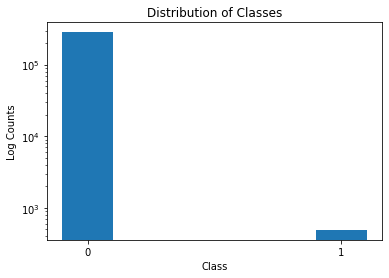

In [3]:
f = plt.figure()
ax = f.add_subplot(1,1,1)
ax.hist(data['Class'], bins = [-0.1, 0.1, 0.9, 1.1], log=True)
ax.set_ylabel("Log Counts")
ax.set_xticks([0, 1])
ax.set_xticklabels(["0", "1"])
ax.set_xlabel("Class")
ax.set_title("Distribution of Classes")

### 2) Create a JSON-AI default object
We will now create JSON-AI syntax for our problem based on its specifications. We can do so by setting up a ``ProblemDefinition``. The ``ProblemDefinition`` allows us to specify the target, the column we intend to predict, along with other details. 

The end goal of JSON-AI is to provide **a set of instructions on how to compile a machine learning pipeline*.

Our target here is called "**Class**", which indicates "0" for no fraud and "1" for fraud. We'll generate the JSON-AI with the minimal syntax:

In [4]:
# Setup the problem definition
problem_definition = {
    'target': 'Class',
}

# Generate the j{ai}son syntax
default_json = json_ai_from_problem(data, problem_definition)


INFO:lightwood-51500:Dropping features: []
INFO:lightwood-51500:Analyzing a sample of 18424
INFO:lightwood-51500:from a total population of 284807, this is equivalent to 6.5% of your data.
INFO:lightwood-51500:Using 15 processes to deduct types.
INFO:lightwood-51500:Infering type for: Time
INFO:lightwood-51500:Infering type for: V1
INFO:lightwood-51500:Infering type for: V2
INFO:lightwood-51500:Infering type for: V3
INFO:lightwood-51500:Infering type for: V4
INFO:lightwood-51500:Infering type for: V5
INFO:lightwood-51500:Infering type for: V6
INFO:lightwood-51500:Infering type for: V7
INFO:lightwood-51500:Infering type for: V8
INFO:lightwood-51500:Infering type for: V9
INFO:lightwood-51500:Infering type for: V10
INFO:lightwood-51500:Infering type for: V11
INFO:lightwood-51500:Infering type for: V12
INFO:lightwood-51500:Infering type for: V13
INFO:lightwood-51500:Infering type for: V14
INFO:lightwood-51500:Column Time has data type integer
INFO:lightwood-51500:Infering type for: V15
INF

MyCustomCleaner.py
MyCustomCleaner
MyCustomSplitter.py
MyCustomSplitter


Lightwood looks at each of the many columns and indicates they are mostly float, with exception of "**Class**" which is binary.

You can observe the JSON-AI if you run the command `print(default_json.to_json())`. Given there are many input features, we won't print it out.

These are the only elements required to get off the ground with JSON-AI. However, we're interested in making a *custom* approach. So, let's make this syntax a file, and introduce our own changes.

In [5]:
with open("default.json", "w") as fp:
   fp.write(default_json.to_json())

### 3) Build your own splitter module

For Lightwood, the goal of a splitter is to intake an initial dataset (pre-processed ideally, although you can run the pre-processor on each DataFrame within the splitter) and return a dictionary with the keys "train", "test", and "dev" (at minimum). Subsequent steps of the pipeline expect the keys "train", "test", and "dev", so it's important you assign datasets to these as necessary. 

We're going to introduce SMOTE sampling in our splitter. SMOTE allows you to quickly learn an approximation to make extra "samples" that mimic the undersampled class. 

We will use the package `imblearn` and `scikit-learn` to quickly create a train/test split and apply SMOTE to our training data only.

**NOTE** This is simply an example of things you can do with the splitter; whether SMOTE sampling is ideal for your problem depends on the question you're trying to answer!

```
from lightwood.api.dtype import dtype
import pandas as pd
import numpy as np
from typing import List, Dict
from itertools import product
from lightwood.api.types import TimeseriesSettings
from lightwood.helpers.log import log


from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split


def MySplitter(
    data: pd.DataFrame,
    target: str,
    pct_train: float = 0.8,
    pct_dev: float = 0.1,
    seed: int = 1,
) -> Dict[str, pd.DataFrame]:
    """
    Custom splitting function


    :param data: Input data
    :param target: Name of the target
    :param pct_train: Percentage of data reserved for training, taken out of full data
    :param pct_dev: Percentage of data reserved for dev, taken out of train data
    :param seed: Random seed for reproducibility

    :returns: A dictionary containing the keys train, test and dev with their respective data frames.
    """

    # Shuffle the data
    data = data.sample(frac=1, random_state=seed).reset_index(drop=True)

    # Split into feature columns + target
    X = data.iloc[:, data.columns != target]  # .values
    y = data[target]  # .values

    # Create a train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, train_size=pct_train, random_state=seed, stratify=data[target]
    )

    X_train, X_dev, y_train, y_dev = train_test_split(
        X, y, test_size=pct_dev, random_state=seed, stratify=y_train
    )

    # Create a SMOTE model and bump up underbalanced class JUST for train data
    SMOTE_model = SMOTE(random_state=seed)

    Xtrain_mod, ytrain_mod = SMOTE_model.fit_resample(X_train, y_train.ravel())

    Xtrain_mod[target] = ytrain_mod
    X_test[target] = y_test
    X_dev[target] = y_dev

    return {"train": Xtrain_mod, "test": X_test, "dev": X_dev}

```

#### Place your custom module in `~/lightwood_modules`

We automatically search for custom scripts in your `~/lightwood_modules` path. Place your file there. Later, you'll see when we autogenerate code, that you can change your import location if you choose.

### 4) Introduce your custom splitter in JSON-AI

Now let's introduce our custom splitter. JSON-AI keeps a lightweight syntax but fills in many default modules (like splitting, cleaning).

For the custom cleaner, we'll work by editing the "splitter" key. We will change properties within it as follows:
(1) "module" - place the name of the function. In our case it will be "MyCustomCleaner.cleaner"
(2) "args" - any keyword argument specific to your cleaner's internals. 

This will look as follows:
```
    "splitter": {
        "module": "MyCustomSplitter.MySplitter",
        "args": {
            "data": "data",
            "target": "$target",
            "pct_train": 0.8,
            "pct_dev": 0.1,
            "seed": 1
        }
    },
```

Let's copy our file `default.json` into `custom.json` and add this block. Then, we can proceed as usual to create python code.

### 5) Generate Python code representing your ML pipeline

Now we're ready to load up our custom JSON-AI and generate the predictor code!

We can do this by first reading in our custom json-syntax, and then calling the function `code_from_json_ai`. 

In [6]:
# Make changes to your JSON-file and load the custom version
with open('custom.json', 'r') as fp:
   modified_json = JsonAI.from_json(fp.read())

#Generate python code that fills in your pipeline
code = code_from_json_ai(modified_json)

print(code)

# Save code to a file (Optional)
with open('custom_splitter_pipeline.py', 'w') as fp:
    fp.write(code)

MyCustomCleaner.py
MyCustomCleaner
MyCustomSplitter.py
MyCustomSplitter
import lightwood
from lightwood.analysis import *
from lightwood.api import *
from lightwood.data import *
from lightwood.encoder import *
from lightwood.ensemble import *
from lightwood.helpers.device import *
from lightwood.helpers.general import *
from lightwood.helpers.log import *
from lightwood.helpers.numeric import *
from lightwood.helpers.parallelism import *
from lightwood.helpers.seed import *
from lightwood.helpers.text import *
from lightwood.helpers.torch import *
from lightwood.mixer import *
import pandas as pd
from typing import Dict, List
import os
from types import ModuleType
import importlib.machinery
import sys


for import_dir in [os.path.expanduser("~/lightwood_modules"), "/etc/lightwood_modules"]:
    if os.path.exists(import_dir) and os.access(import_dir, os.R_OK):
        for file_name in list(os.walk(import_dir))[0][2]:
            print(file_name)
            if file_name[-3:] != ".py":


As you can see, an end-to-end pipeline of our entire ML procedure has been generating. There are several abstracted functions to enable transparency as to what processes your data goes through in order to build these models.

The key steps of the pipeline are as follows:

(1) Run a **statistical analysis** with `analyze_data` <br>
(2) Clean your data with `preprocess` <br>
(3) Make a training/dev/testing split with `split` <br>
(4) Prepare your feature-engineering pipelines with `prepare` <br>
(5) Create your features with `featurize` <br>
(6) Fit your predictor models with `fit` <br>

You can customize this further if necessary, but you have all the steps necessary to train a model!

We recommend familiarizing with these steps by calling the above commands, ideally in order. Some commands (namely `prepare`, `featurize`, and `fit`) do depend on other steps.

If you want to omit the individual steps, we recommend your simply call the `learn` method, which compiles all the necessary steps implemented to give your fully trained predictive models starting with unprocessed data! 

### 6) Call python to run your code and see your preprocessed outputs

Once we have code, we can turn this into a python object by calling `predictor_from_code`. This instantiates the `PredictorInterface` object. 

This predictor object can be then used to run your pipeline.

In [7]:
# Turn the code above into a predictor object
predictor = predictor_from_code(code)

MyCustomCleaner.py
MyCustomCleaner
MyCustomSplitter.py
MyCustomSplitter


In [8]:
# Pre-process the data
cleaned_data = predictor.preprocess(data)
train_test_data = predictor.split(cleaned_data)

INFO:lightwood-51500:Cleaning the data
INFO:lightwood-51500:Splitting the data into train/test
/home/natasha/lightwood_modules/MyCustomSplitter.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[target] = y_test
/home/natasha/lightwood_modules/MyCustomSplitter.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_dev[target] = y_dev


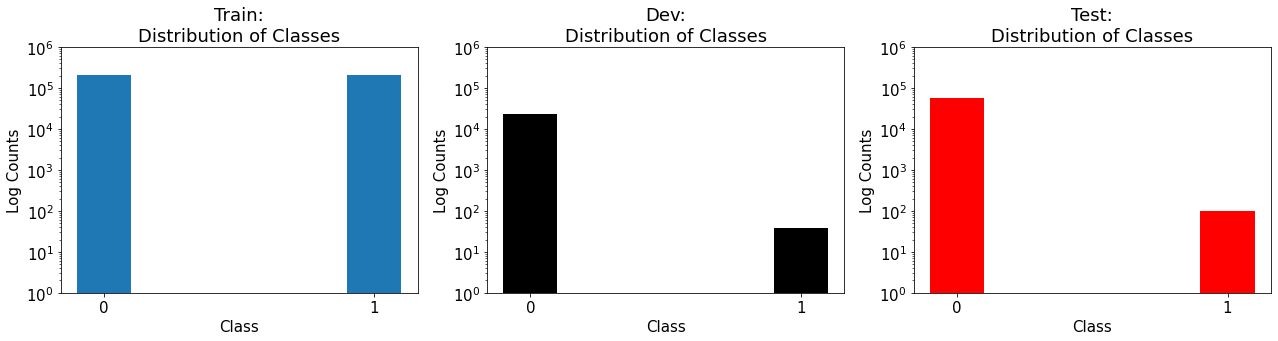

In [9]:
plt.rcParams['font.size']=15
f = plt.figure(figsize=(18, 5))

ax = f.add_subplot(1,3,1)
ax.hist(train_test_data["train"]['Class'], bins = [-0.1, 0.1, 0.9, 1.1], log=True)
ax.set_ylabel("Log Counts")
ax.set_xticks([0, 1])
ax.set_xticklabels(["0", "1"])
ax.set_xlabel("Class")
ax.set_title("Train:\nDistribution of Classes")
ax.set_ylim([1, 1e6])

ax = f.add_subplot(1,3,2)
ax.hist(train_test_data["dev"]['Class'], bins = [-0.1, 0.1, 0.9, 1.1], log=True, color='k')
ax.set_ylabel("Log Counts")
ax.set_xticks([0, 1])
ax.set_xticklabels(["0", "1"])
ax.set_xlabel("Class")
ax.set_title("Dev:\nDistribution of Classes")
ax.set_ylim([1, 1e6])


ax = f.add_subplot(1,3,3)
ax.hist(train_test_data["test"]['Class'], bins = [-0.1, 0.1, 0.9, 1.1], log=True, color='r')
ax.set_ylabel("Log Counts")
ax.set_xticks([0, 1])
ax.set_xticklabels(["0", "1"])
ax.set_xlabel("Class")
ax.set_title("Test:\nDistribution of Classes")
ax.set_ylim([1, 1e6])

f.tight_layout()

As you can see, our splitter has greatly increased the representation of the minority class within the training data, but not so for the testing or dev data.

We hope this tutorial was informative on how to introduce a **custom splitter method** to your datasets! For more customization tutorials, please check our [documentation](https://lightwood.io/tutorials.html).

If you want to download the Jupyter-notebook version of this tutorial, check out the source github location found here: `lightwood/docssrc/source/tutorials/custom_splitter`. 